# Domaine_Petrusson

Domaine Petrusson (“the company”) is a winery based in South-Central Nebraska with revenues deriving from two sectors: consumer discretionary and hospitality and leisure. Sales of wine are local and regional, driven primarily by customers visiting vineyard for tastings and special events. The company is a farm winery (vineyard and winery on premise) that operates in agriculture (growing grapes and maintaining trellis infrastructure), food and drink (production of wine and food to accentuate local produce), and hospitality and leisure (hosting special events and short-term stays). Critical to operations is a library where research of viticulture and oenology in literature and digital media is conducted. Locations include vineyard, winery, event space with kitchen, library, and outdoor venue.

The company is part of larger agricultural land held by a private firm run by a family for three generations. The company has one executive with seasonal employees as needed for operations. The location of operations is within the vicinity of, but not exclusive to, the village of Bertrand, Nebraska. The company follows a definition of “domaine” in French as “area of control.” Grapes grown or cared for on family farm or in nearby vineyards will be used. The idea relates to the concept of “action independence” in global agriculture. (Practices that increase productivity through biodiversity in an era of climate extremes.) In short, using grapes that are in the domain of executive’s control or sphere of knowledge.

# Business Model

Below is a diagram illustrating flow of operations with revenue and promotional opportunities: 

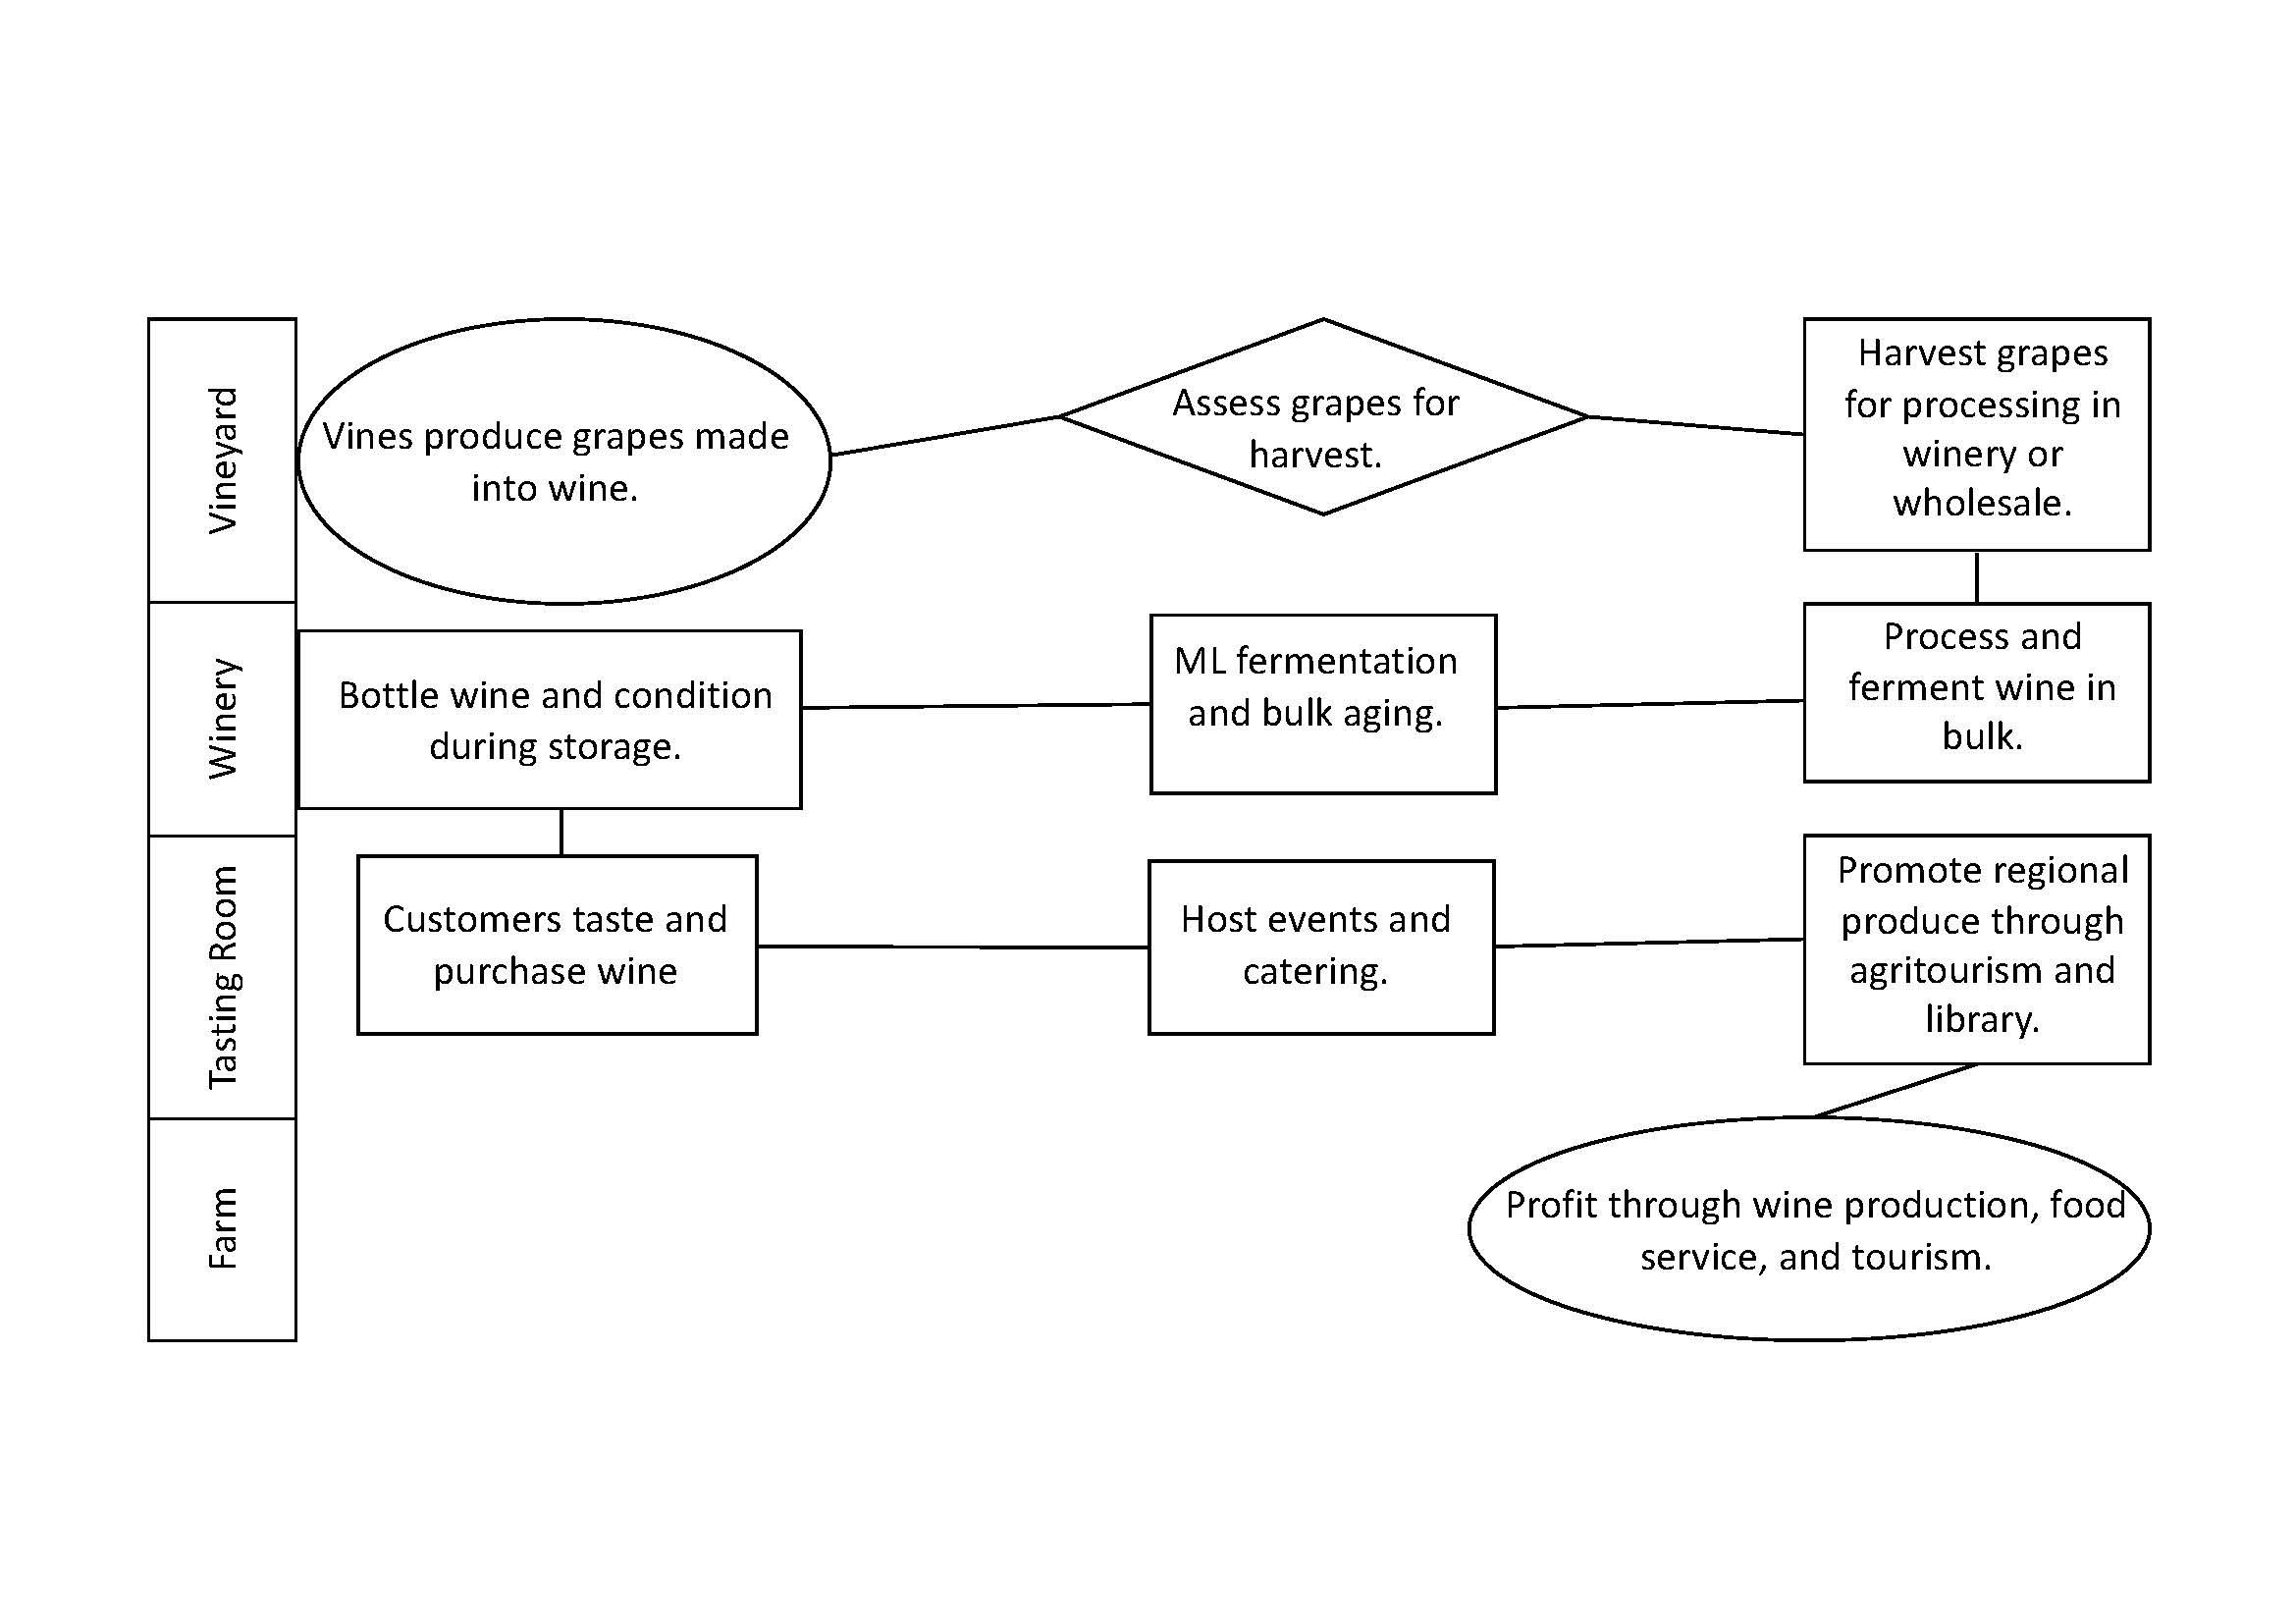

The action point is in the vineyard when assessing grapes. Within the database is an assessment table. Quality of berries are dependent upon several factors such as health and age of vine, foliage, pests,
and disease. Further development of assessment will include application of sprays: date and time, type and amount of chemical, and climate conditions. Another area for development is visual assessment through historical photos and machine learning. Smart agriculture with the ability to scale Internet of Things (IoT) is the goal. Reducing human labor, a documented constraint of vineyards throughout history, is crucial. IoT machines will become common in vineyards. Potential tasks include pruning, pest and disease management, and harvest.  

The company focuses on sales of wine and related activities like dining and leisure. The following diagram shows the business flow of a customer visiting the winery:

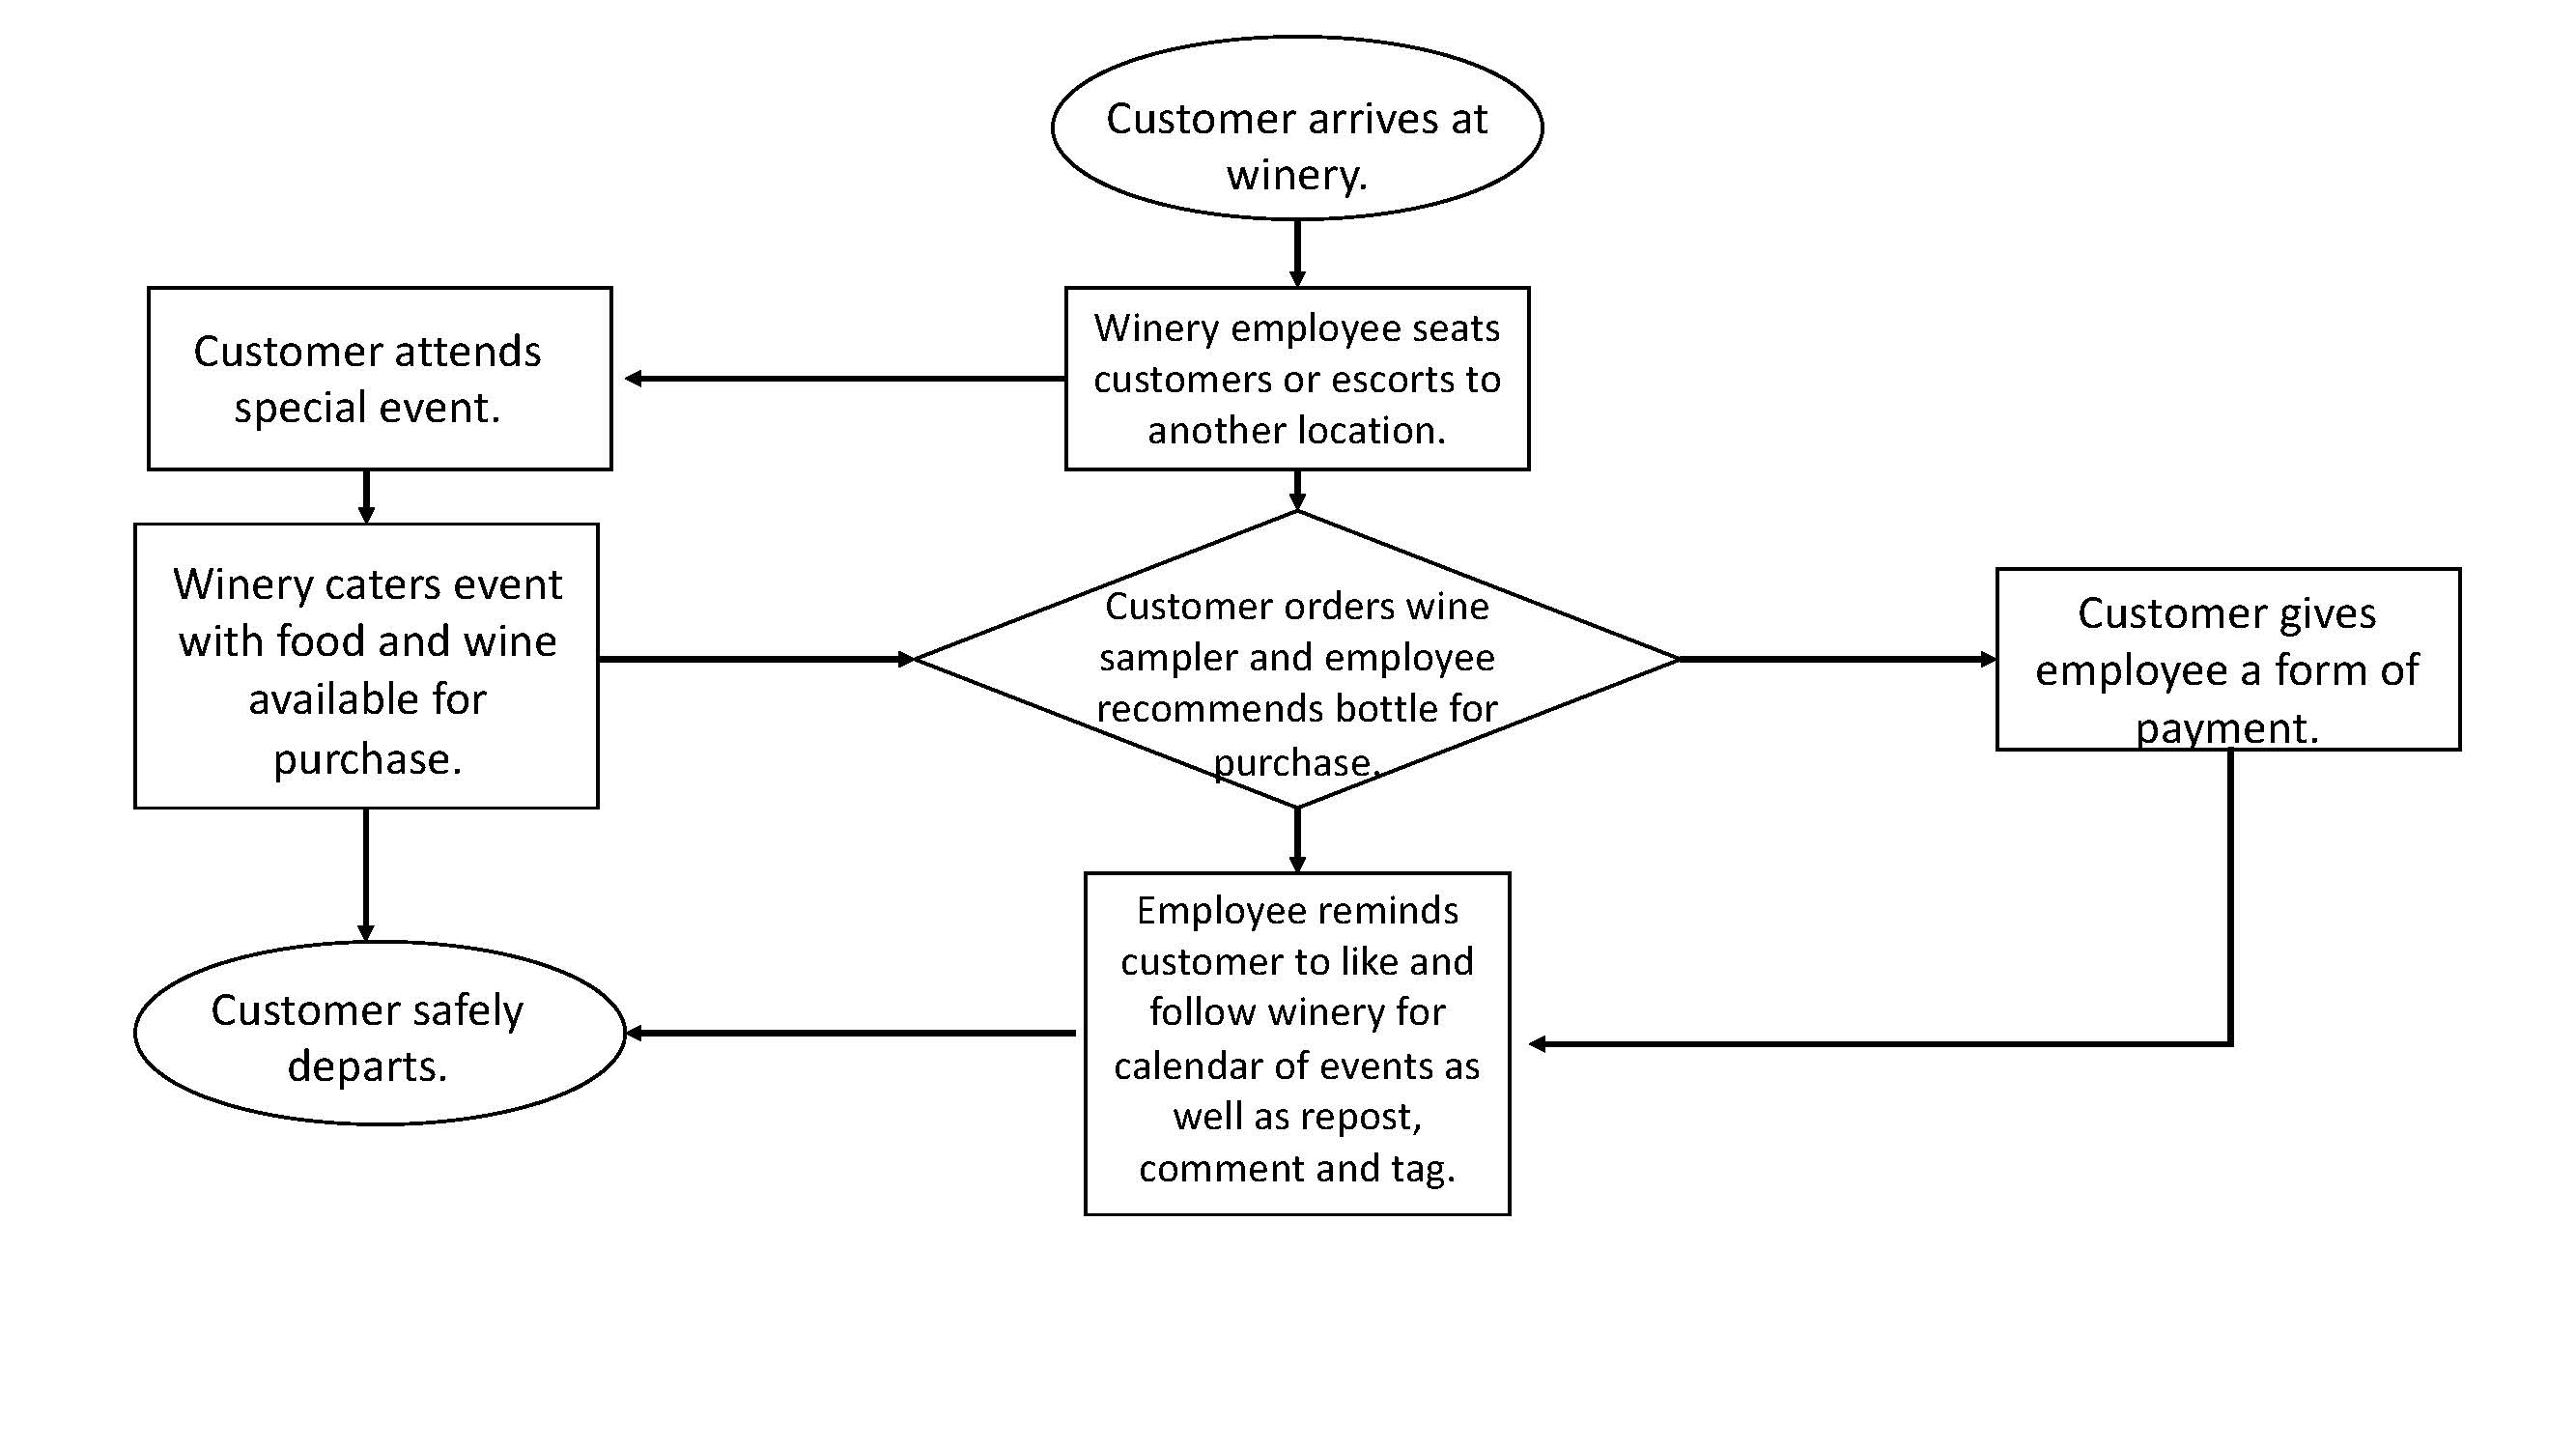

The customer arrives for wine tasting or for special events. Special events can be, but not limited to, the following: 

- catered dinners 
- live performances
- special events
- educational promotions.

Employee will escort customer to appropriate location and offer suggestions for wine to sample. Customer purchases wine sampler, individual bottle, or case of wine. After transacting purchase, employee reminds customer to follow social media page for events and promotions. (Digital engagement is critical.) Last, customer safely departs premise. 

Sales of wine represents a significant proportion of future revenue generated from family farm. Core growth depends on leveraging technology to increase productivity of land. Data generated from viticultural and oenologial activities is the spearhead for broader operations. The vineyard, winery, and tasting room fit into an example of capturing agricultural data for analysis. The example begins a new way to operate family farm. 

## Webscrape nursery website for data

Information from a nursery was necessary for the database. Below is the information as displayed on the nursery's website:

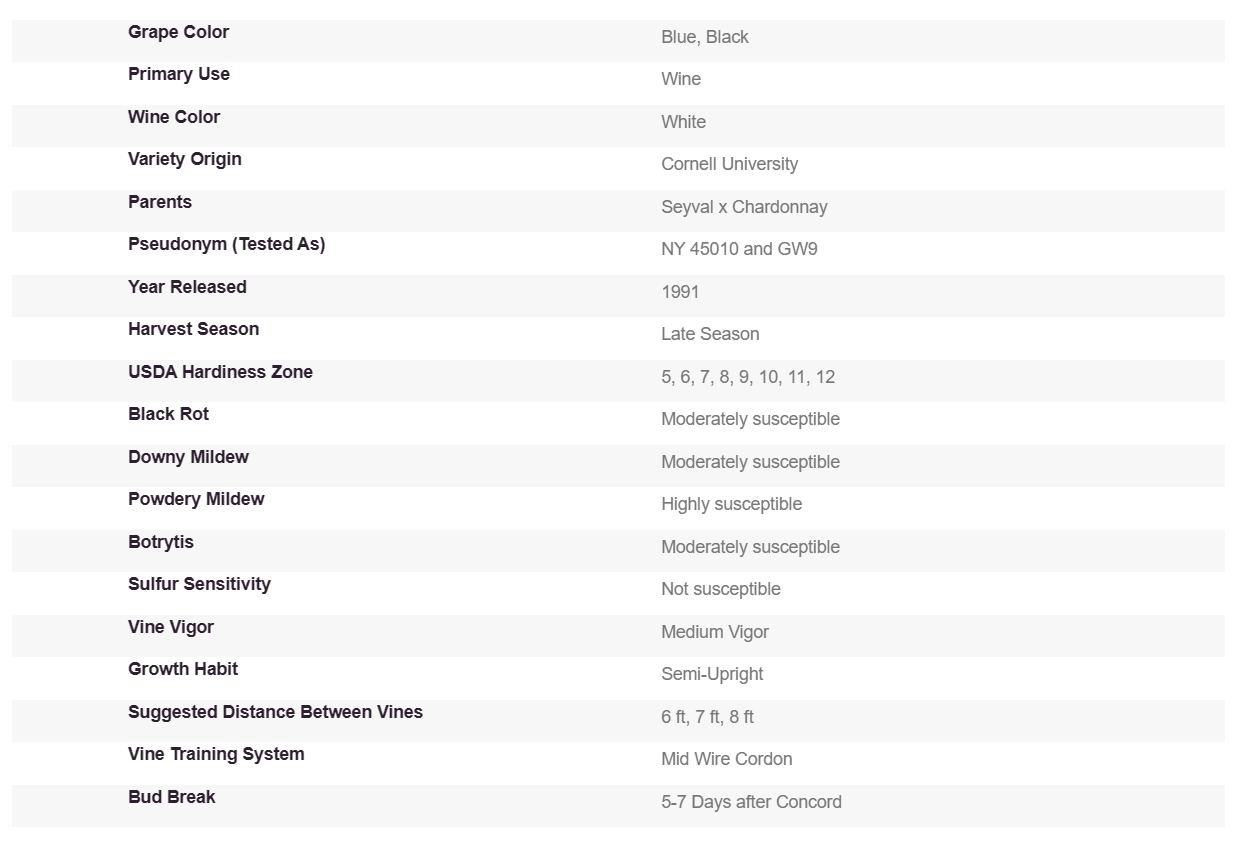

The following code below was used to scrape information from the website:

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import random
import string


url_list = ['https://doubleavineyards.com/chardonel',
'https://doubleavineyards.com/chelois',
'https://doubleavineyards.com/concord',
'https://doubleavineyards.com/edelweiss',
'https://doubleavineyards.com/frontenac',
'https://doubleavineyards.com/frontenac-blanc',
'https://doubleavineyards.com/frontenac-gris',
'https://doubleavineyards.com/marechal-foch',
'https://doubleavineyards.com/noiret',
'https://doubleavineyards.com/itasca',
'https://doubleavineyards.com/geneva-red',
'https://doubleavineyards.com/brianna',
'https://doubleavineyards.com/leon-millot',
'https://doubleavineyards.com/marquette',
'https://doubleavineyards.com/la-crescent']



variety_data = create_variety_data(url_list)
variety_data.to_csv()



page = requests.get("https://doubleavineyards.com/chardonel")
soup = BeautifulSoup(page.content, "html.parser")
variety_html = soup.find_all("table", class_="data table additional-attributes")
variety_characteristic = soup.find_all("tr")
variety_name = soup.find("h1", class_="product-name").text
# print(variety_name)
vc_list = []
vc_values = []
for i in variety_characteristic:
    column = i.find("th", class_="col label").text
    values = i.find("td", class_="col data").text
    vc_list.append(column)
    vc_values.append(values)
vc_list.append("Variety Name")
vc_values.append(variety_name)
vc_id = ''.join(random.choices(string.ascii_uppercase + string.digits, k=6))
vc_list.append("Variety ID")
vc_values.append(vc_id)
# print(vc_list)
# print(vc_values)
vc_dict = dict(zip(vc_list, vc_values))
# print(vc_dict)
vc_df = pd.DataFrame(vc_dict, index=[0])
# print(vc_df["Variety ID"])

## DDL schema in DBeaver

Primary and foreign key constraints were placed upon the tables in SQL using DBeaver. Two tables were problematic when assigning foreign keys:

- vinification
- harvest

The issue was resolved by correcting the length of varchar referenced as a foreign key in the tables. Specifically, "Harvest ID" needed to be varchar (6) in length. See screenshots below:

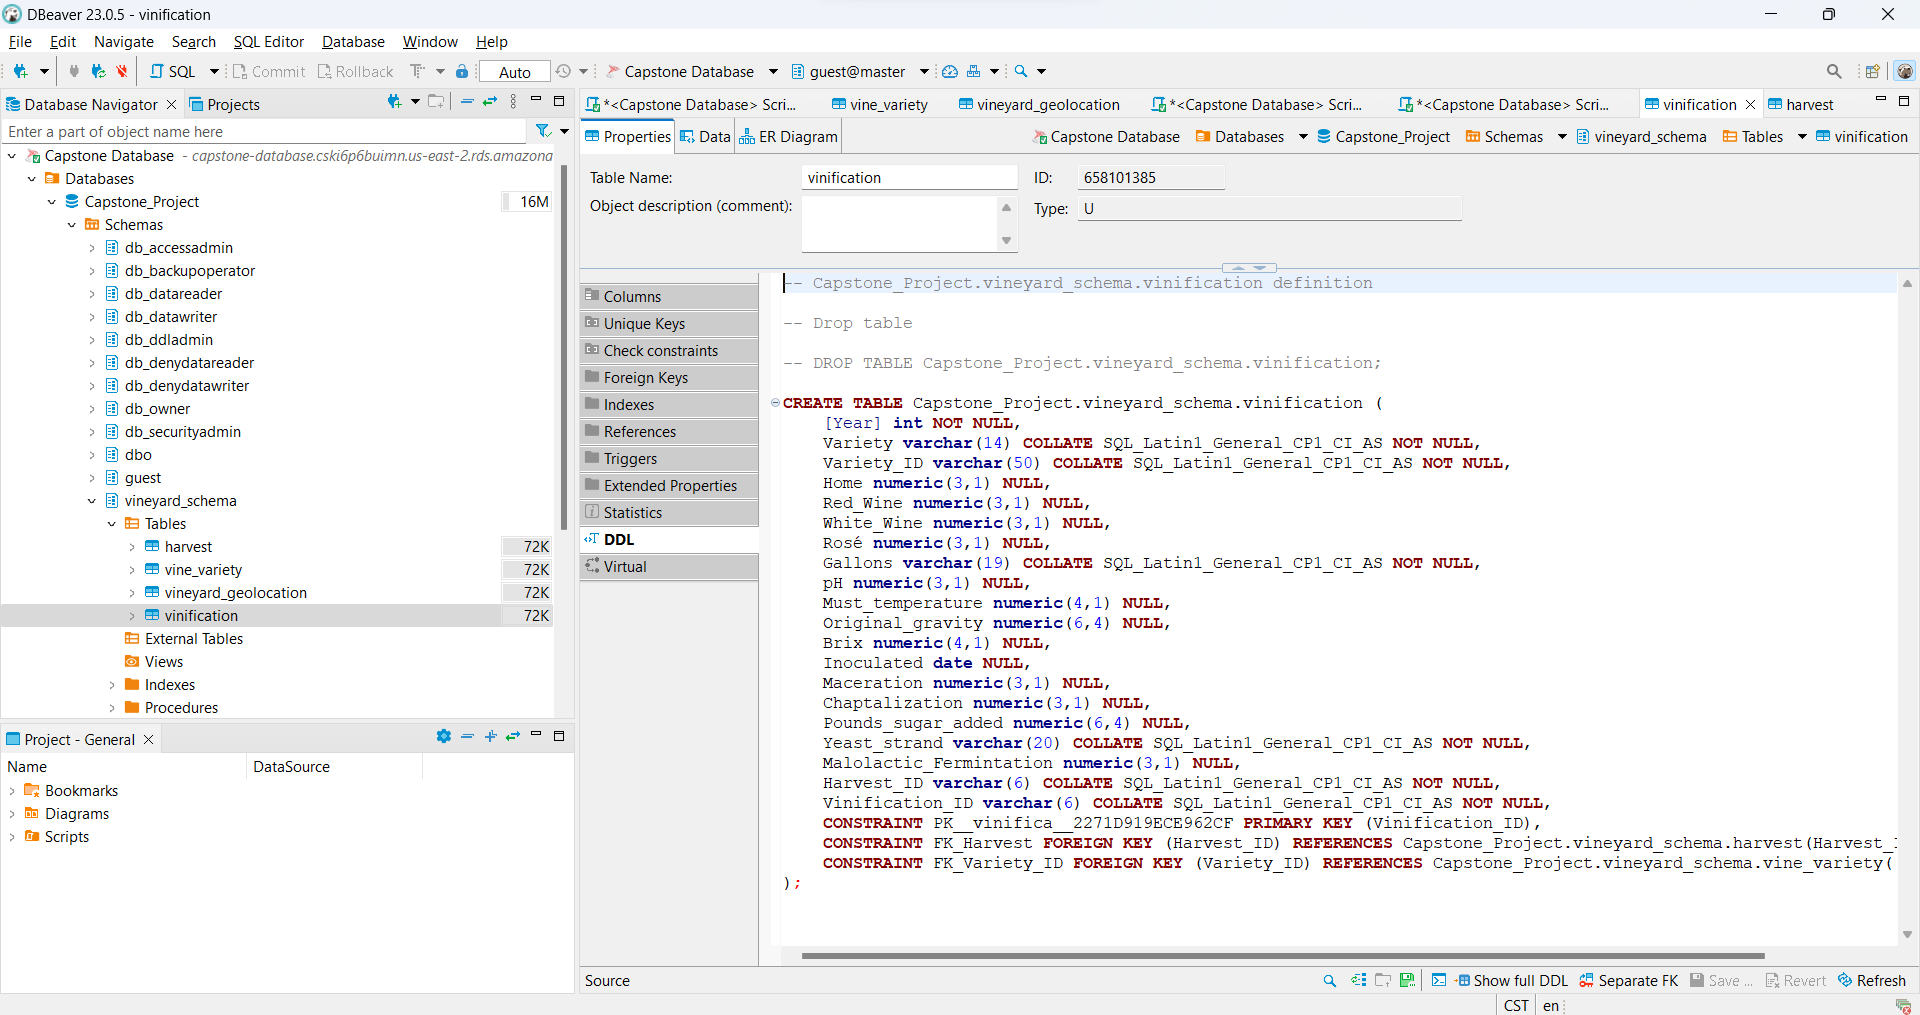

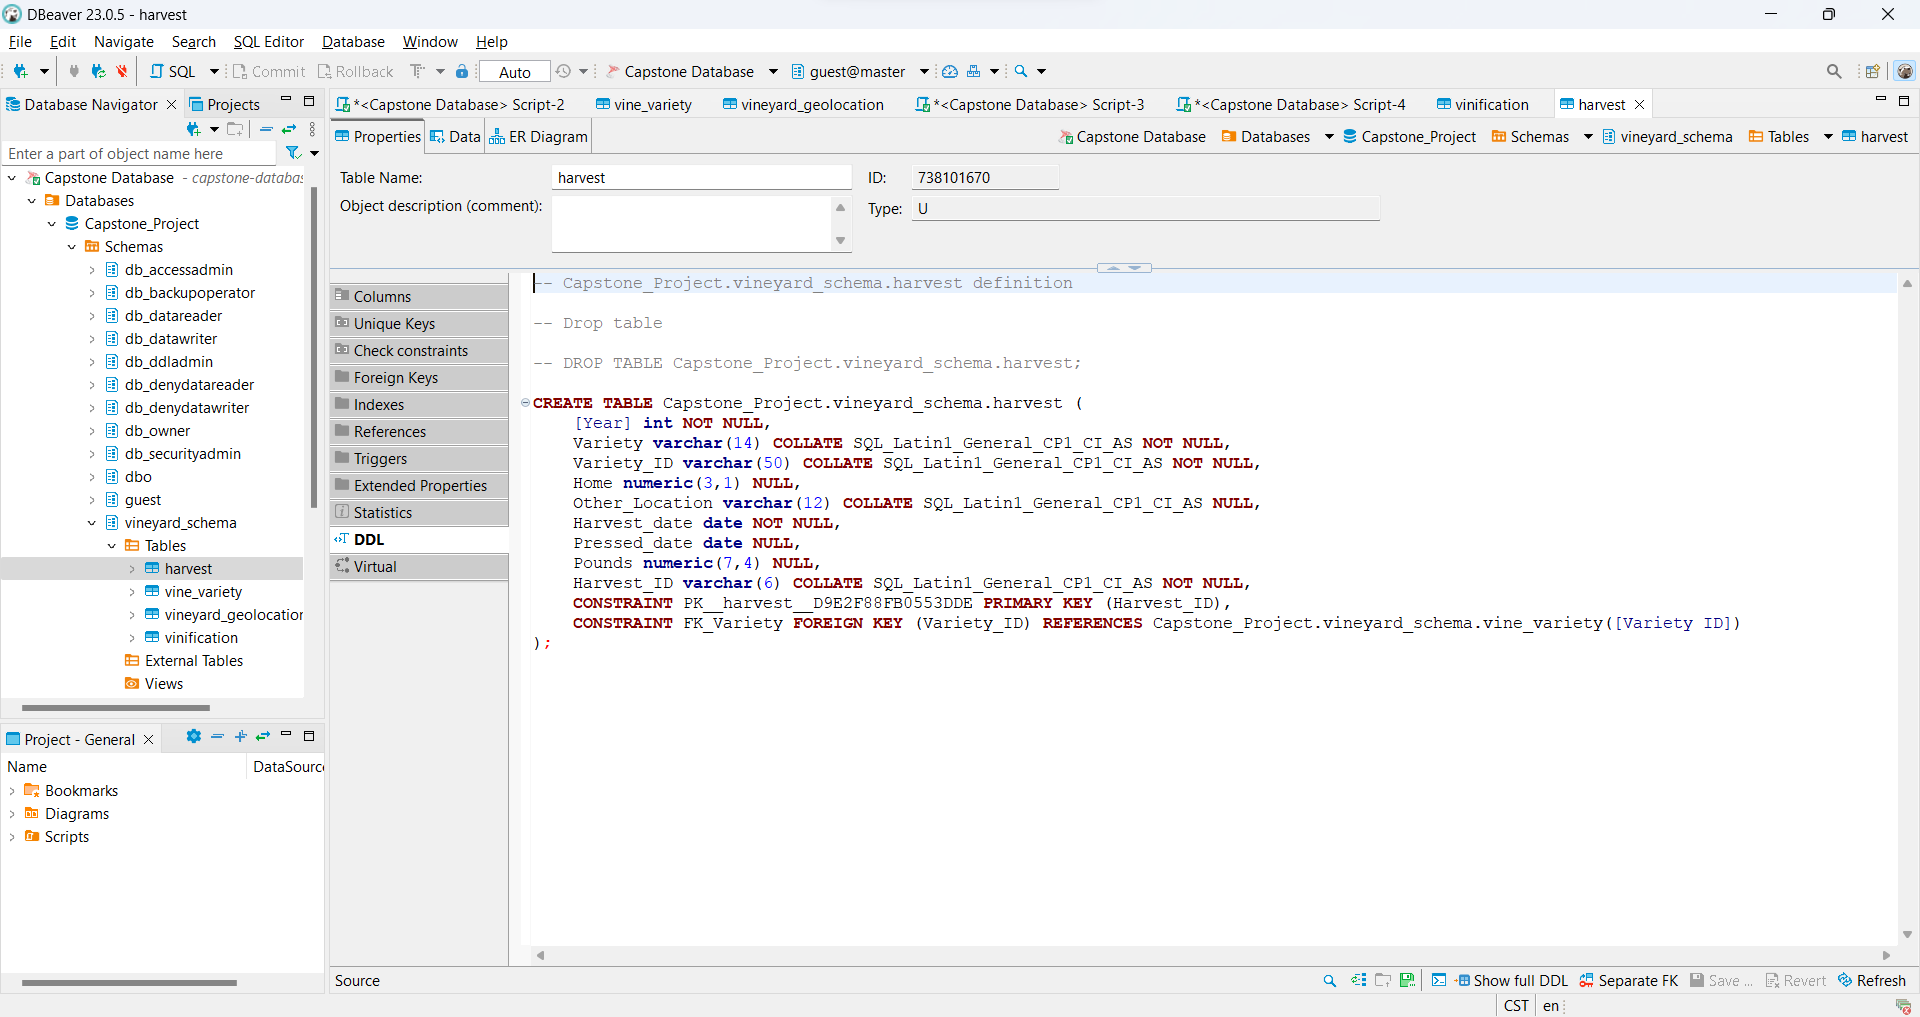

## Extract tables from database and ingest into s3 bucket

Data from vineyard over several years is stored in a relational database (RDS) in Amazon Web Services (AWS). The first step is to extract data from the RDS to a local file. To accomplish this step, definitions for server, user name, permission, tables, output folder, and connections are written. A for loop is written based upon the definition in order to export data to a comma separated file (csv). 

The next step is to use Boto3 to upload extracted files to a simple storage service (S3) on AWS. The bucket name and key name are defined in order to upload files. Once uploaded, the data is contained within a data lake to use AWS Glue Crawler. The crawler will query stored data for use by developers and store metadata. 

Here are the steps described above: 

- Extract data from RDS 
- Export data as csv 
- Upload files to S3 with Boto3 
- Query data with Glue Crawler 
- Apply data to use case

In [9]:
import boto3
import pyodbc
import csv
i

# Preliminary: Store login credentials as JSON on local file

username_dict = []
password_dict = []

with open('./capstone_admin.json') as f:
    df = json.load(f)
    
for item in df:
    username_dict.append(item['USER'])
    password_dict.append(item['PASSWORD'])
    
username = ''.join(map(str, username_dict))
password = ''.join(map(str, password_dict))

# 1. Export data from MSSQL RDS instance to a local file

SERVER = 'capstone-database.cski6p6buimn.us-east-2.rds.amazonaws.com'
DATABASE = 'Capstone_Project'
USER = username
PASSWORD = password
TABLE_LIST = ['vine_variety', 'vineyard_geolocation', 'harvest', 'vinification', 'assessment']
OUTPUT_FOLDER = './files_to_ingest'

# Define the connection string
connection_string = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={SERVER};DATABASE={DATABASE};UID={USER};PWD={PASSWORD}'

# Connect to the database
conn = pyodbc.connect(connection_string)
cursor = conn.cursor()

# Export data to a CSV

for table in TABLE_LIST:
    cursor.execute(f'SELECT * FROM vineyard_schema.{table}')
    # print(cursor.description)
    OUTPUT_FILE = f'{OUTPUT_FOLDER}/{table}.csv'
    with open(OUTPUT_FILE, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)

        # Write headers
        columns = [column[0] for column in cursor.description]
        writer.writerow(columns)

        # Write data
        for row in cursor.fetchall():
            writer.writerow(row)

# 2. Use Boto3 to upload the local file to an S3 bucket

    BUCKET_NAME = 'capstone-project-maryvine'
    KEY_NAME = f'capstone-project/{table}/{table}.csv'

#     s3_client = boto3.client('s3')
#     s3_client.upload_file(OUTPUT_FILE, BUCKET_NAME, KEY_NAME)

#     print(f"Data from {table} has been uploaded to {BUCKET_NAME}/{KEY_NAME}")

cursor.close()
conn.close()

Below is a screenshot of the tables created in the S3 bucket:

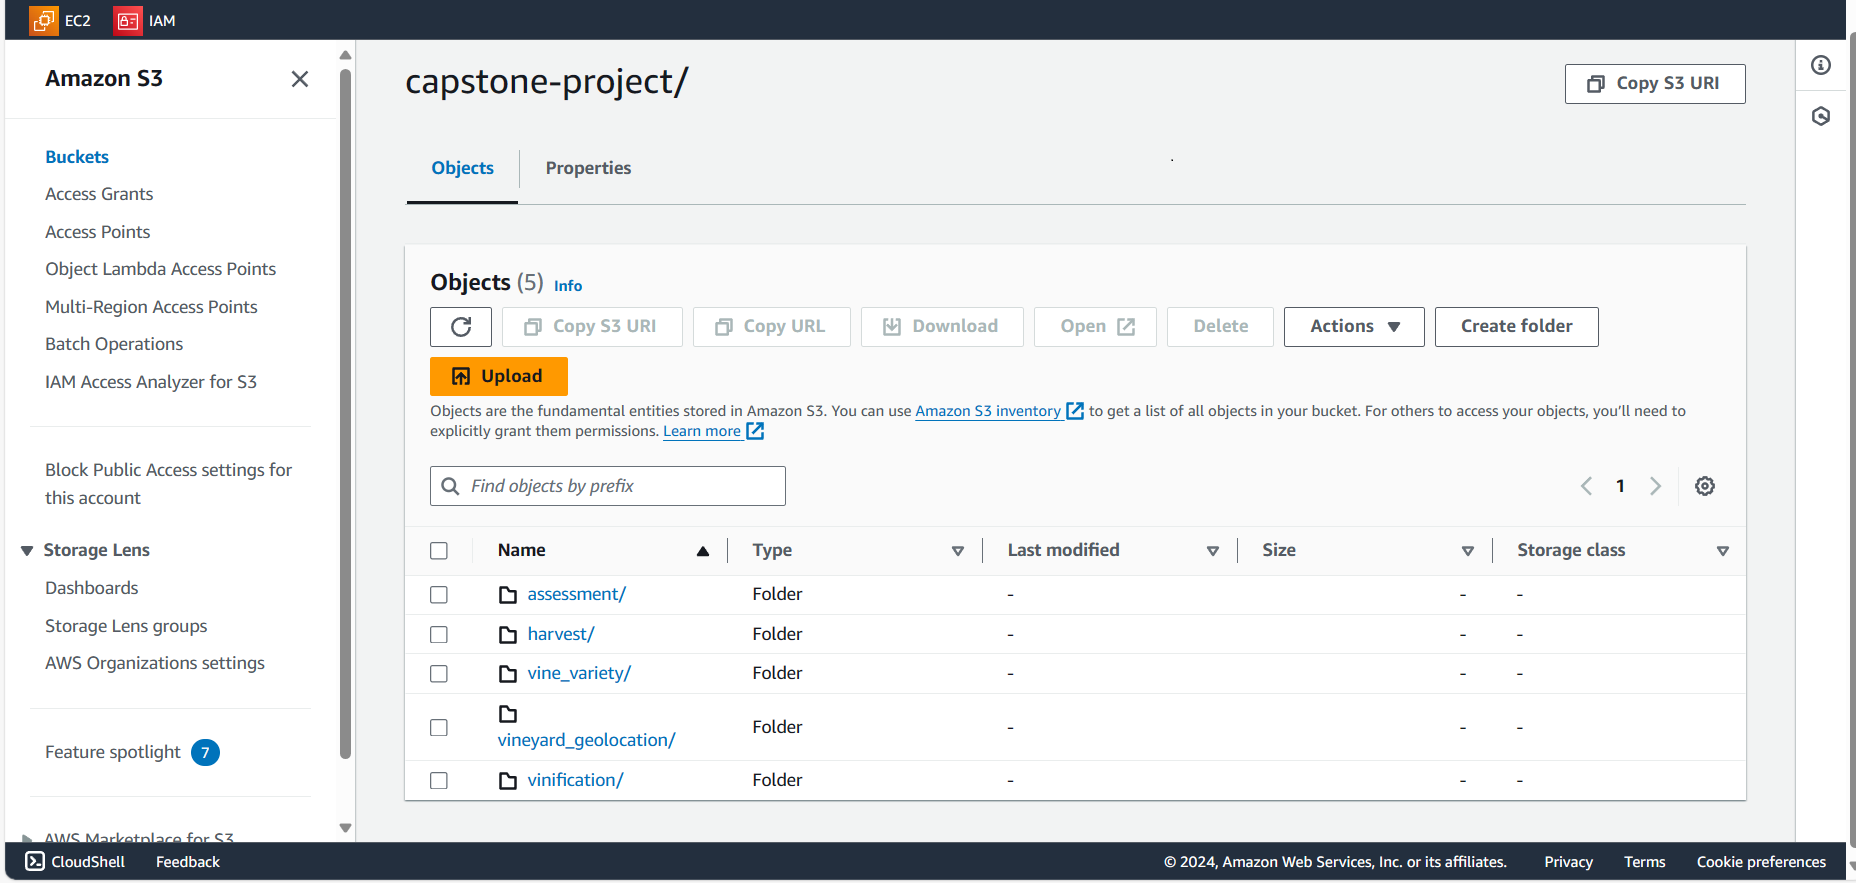

Below are screen shots of the crawler in Glue plus classifiers needed to process two tables that were further refined (more information further below):

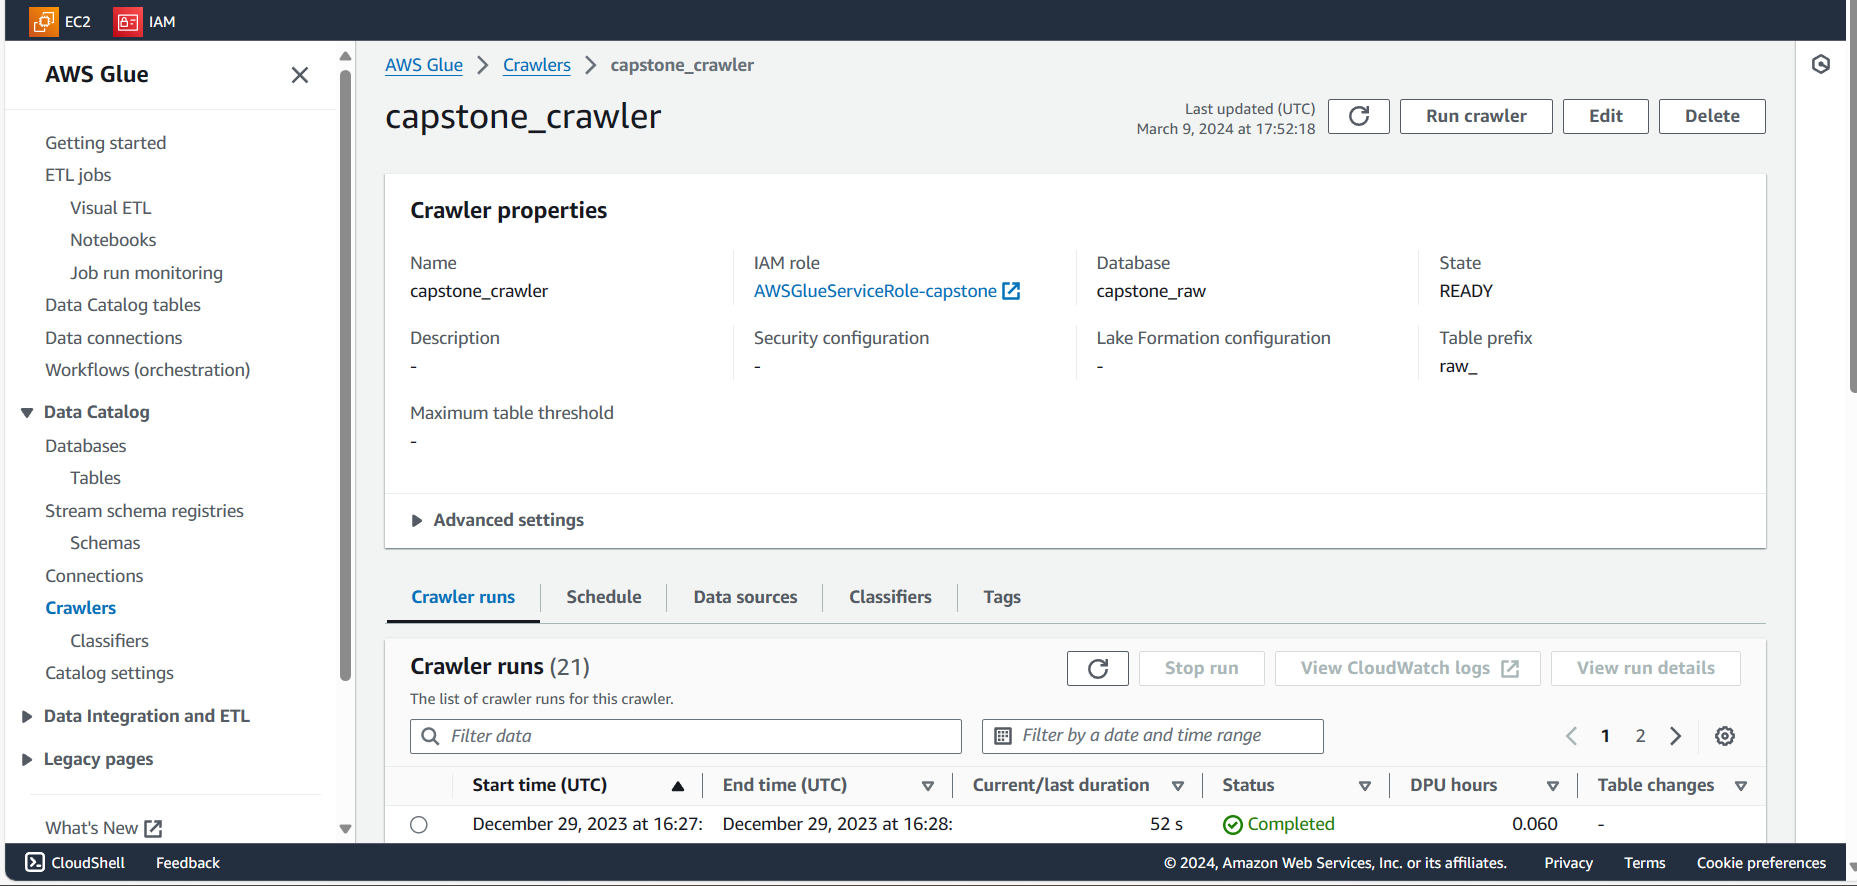

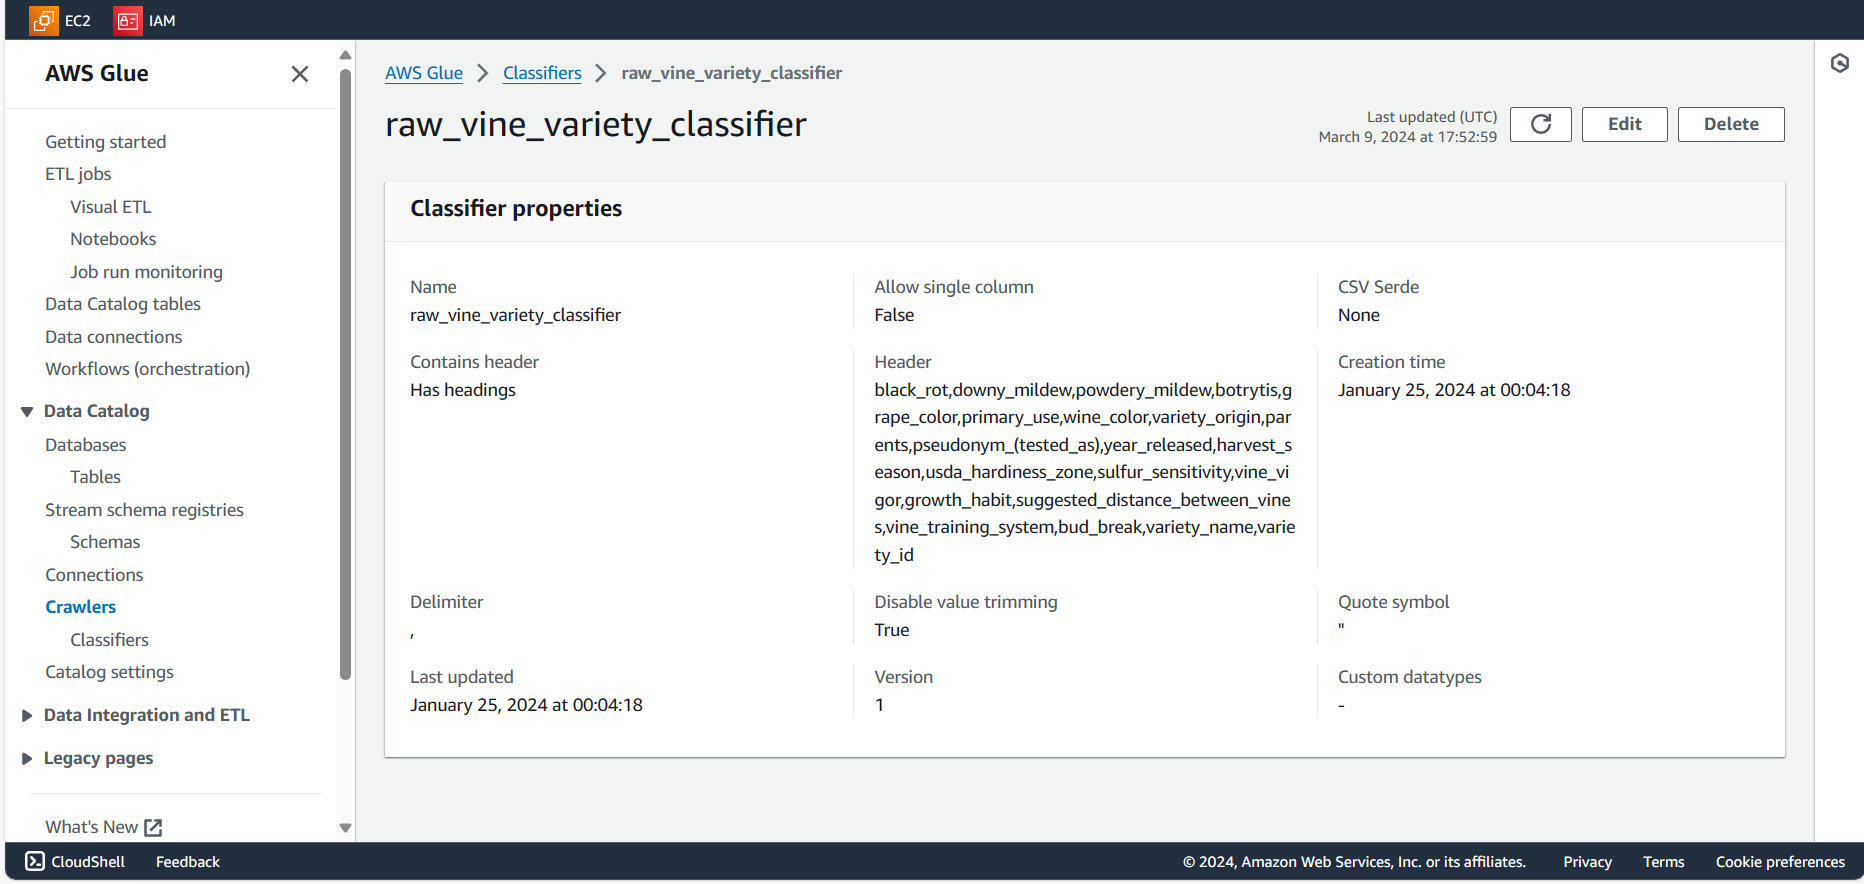

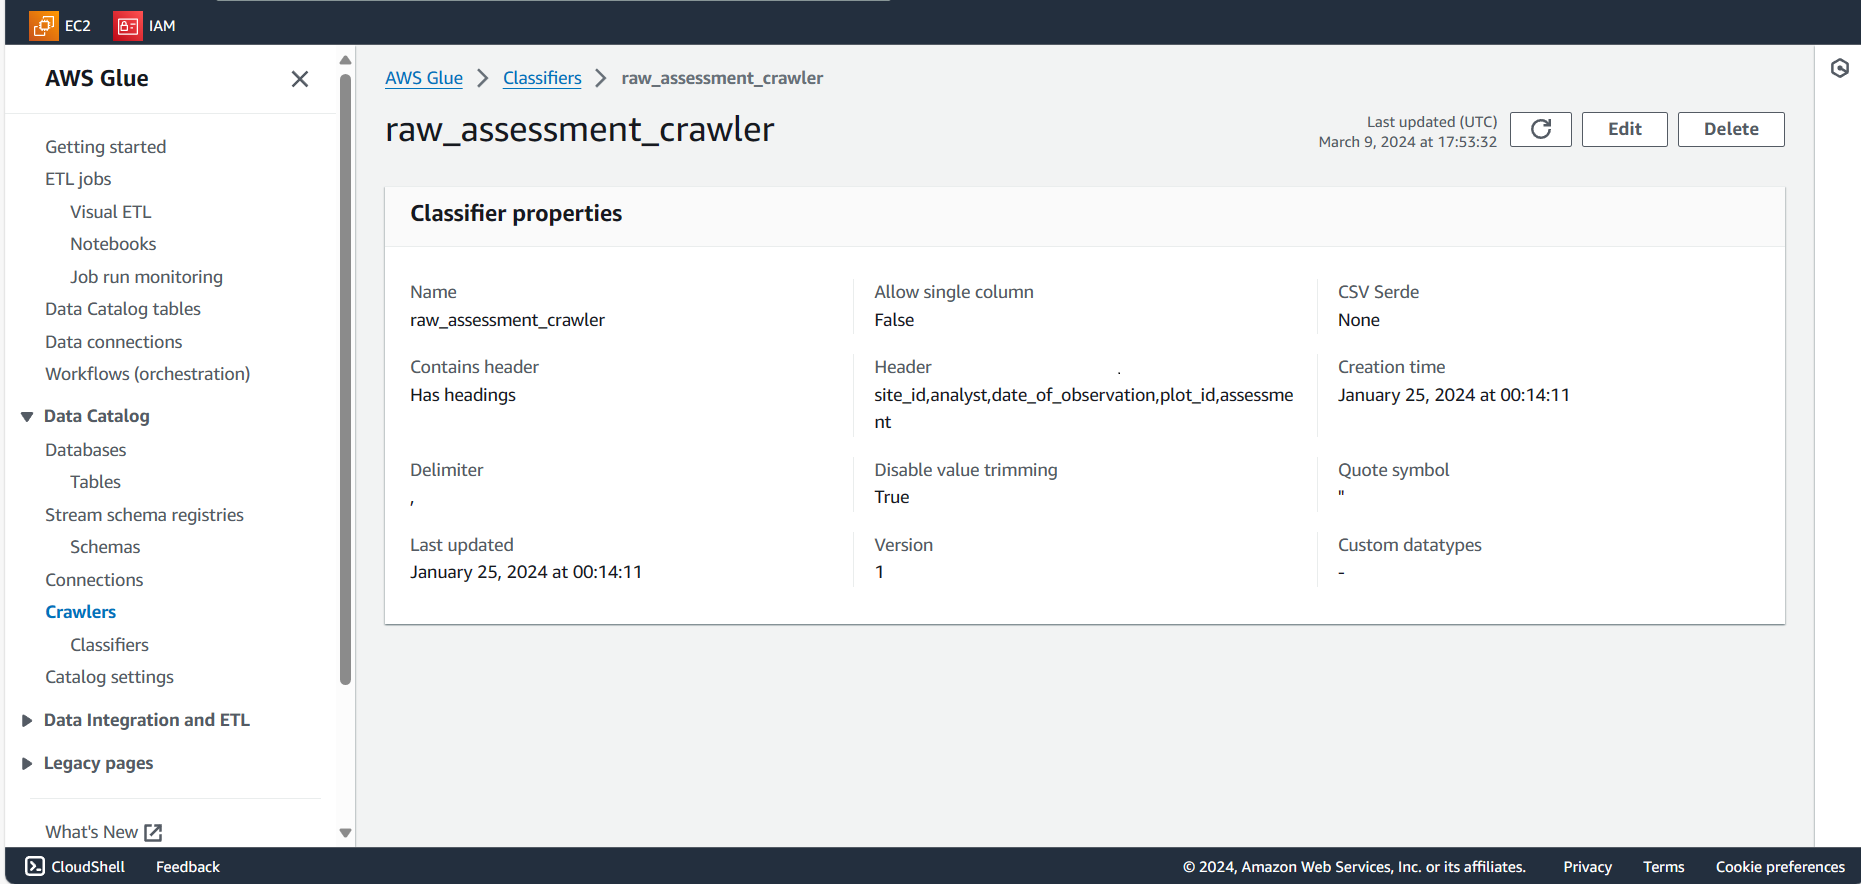

## Further preprocessing of tables vine_variety and assessment

Further preprocessing was necessary for two tables, vine_variety and assessment, before data lake formation. A crawler in AWS Glue was unable to process the tables correctly from the s3 bucket created above. The steps taken below show that using lowercase letters in column names and removing spaces between words with underscores was performed.

The crawler in Glue, with a csv classifier, was able to process the tables in order to complete data lake formation.

In [4]:
import pandas as pd

assessment_df = pd.read_csv('./files_to_ingest/assessment.csv')
vine_variety_df = pd.read_csv('./files_to_ingest/vine_variety.csv')

print(vine_variety_df)

                 Black Rot            Downy Mildew          Powdery Mildew  \
0                  Unknown    Slightly susceptible    Slightly susceptible   
1     Slightly susceptible  Moderately susceptible    Slightly susceptible   
2     Slightly susceptible    Slightly susceptible  Moderately susceptible   
3     Slightly susceptible    Slightly susceptible  Moderately susceptible   
4   Moderately susceptible    Slightly susceptible  Moderately susceptible   
5   Moderately susceptible    Slightly susceptible  Moderately susceptible   
6   Moderately susceptible    Slightly susceptible  Moderately susceptible   
7     Slightly susceptible    Slightly susceptible      Highly susceptible   
8   Moderately susceptible    Slightly susceptible  Moderately susceptible   
9     Slightly susceptible  Moderately susceptible  Moderately susceptible   
10  Moderately susceptible      Highly susceptible  Moderately susceptible   
11  Moderately susceptible  Moderately susceptible      Highly s

In [10]:
vine_variety_df.columns = [x.lower() for x in vine_variety_df.columns]

print(vine_variety_df)

                 black rot            downy mildew          powdery mildew  \
0                  Unknown    Slightly susceptible    Slightly susceptible   
1     Slightly susceptible  Moderately susceptible    Slightly susceptible   
2     Slightly susceptible    Slightly susceptible  Moderately susceptible   
3     Slightly susceptible    Slightly susceptible  Moderately susceptible   
4   Moderately susceptible    Slightly susceptible  Moderately susceptible   
5   Moderately susceptible    Slightly susceptible  Moderately susceptible   
6   Moderately susceptible    Slightly susceptible  Moderately susceptible   
7     Slightly susceptible    Slightly susceptible      Highly susceptible   
8   Moderately susceptible    Slightly susceptible  Moderately susceptible   
9     Slightly susceptible  Moderately susceptible  Moderately susceptible   
10  Moderately susceptible      Highly susceptible  Moderately susceptible   
11  Moderately susceptible  Moderately susceptible      Highly s

In [11]:
assessment_df.columns = [x.lower() for x in assessment_df.columns]

print(assessment_df)

    site_id          analyst date_of_observation  plot_id assessment
0    MRV001  Nathan Peterson          2023-07-09  T014001         gt
1       NaN              NaN                 NaN  T014002          x
2       NaN              NaN                 NaN  T014003          x
3       NaN              NaN                 NaN  T014004          x
4       NaN              NaN                 NaN  T014005          x
..      ...              ...                 ...      ...        ...
178     NaN              NaN                 NaN  T011008          x
179     NaN              NaN                 NaN  T011009          x
180     NaN              NaN                 NaN  T011010          x
181     NaN              NaN                 NaN  T011011          x
182     NaN              NaN                 NaN  T011012          x

[183 rows x 5 columns]


In [17]:
vine_variety_df = vine_variety_df.rename(columns=lambda name: name.replace(' ', '_'))

print(vine_variety_df)

                 black_rot            downy_mildew          powdery_mildew  \
0                  Unknown    Slightly susceptible    Slightly susceptible   
1     Slightly susceptible  Moderately susceptible    Slightly susceptible   
2     Slightly susceptible    Slightly susceptible  Moderately susceptible   
3     Slightly susceptible    Slightly susceptible  Moderately susceptible   
4   Moderately susceptible    Slightly susceptible  Moderately susceptible   
5   Moderately susceptible    Slightly susceptible  Moderately susceptible   
6   Moderately susceptible    Slightly susceptible  Moderately susceptible   
7     Slightly susceptible    Slightly susceptible      Highly susceptible   
8   Moderately susceptible    Slightly susceptible  Moderately susceptible   
9     Slightly susceptible  Moderately susceptible  Moderately susceptible   
10  Moderately susceptible      Highly susceptible  Moderately susceptible   
11  Moderately susceptible  Moderately susceptible      Highly s

In [18]:
assessment_df = assessment_df.rename(columns=lambda name: name.replace(' ', '_'))

print(assessment_df)

    site_id          analyst date_of_observation  plot_id assessment
0    MRV001  Nathan Peterson          2023-07-09  T014001         gt
1       NaN              NaN                 NaN  T014002          x
2       NaN              NaN                 NaN  T014003          x
3       NaN              NaN                 NaN  T014004          x
4       NaN              NaN                 NaN  T014005          x
..      ...              ...                 ...      ...        ...
178     NaN              NaN                 NaN  T011008          x
179     NaN              NaN                 NaN  T011009          x
180     NaN              NaN                 NaN  T011010          x
181     NaN              NaN                 NaN  T011011          x
182     NaN              NaN                 NaN  T011012          x

[183 rows x 5 columns]


In [19]:
vine_variety_df.to_csv('./files_to_ingest/vine_variety.csv', index=False)

In [20]:
assessment_df.to_csv('./files_to_ingest/assessment.csv', index=False)

## Data lake formation with Glue for gold-tier data warehousing

The next step after further preprocessing is run a Glue crawler with classifiers and then later query tables created by Glue. The steps required are below:

- create data lake formation inside of S3 using Glue
- create an organized data lake to query ad hoc
- quick analytics for downstream use
- build warehouse model for downstream use
- two different locations of data lake for unprocessed and next-step processed data

Serverless Redshift was used to build the warehouse model for downstream use. Below is a screenshot of a query of the data:

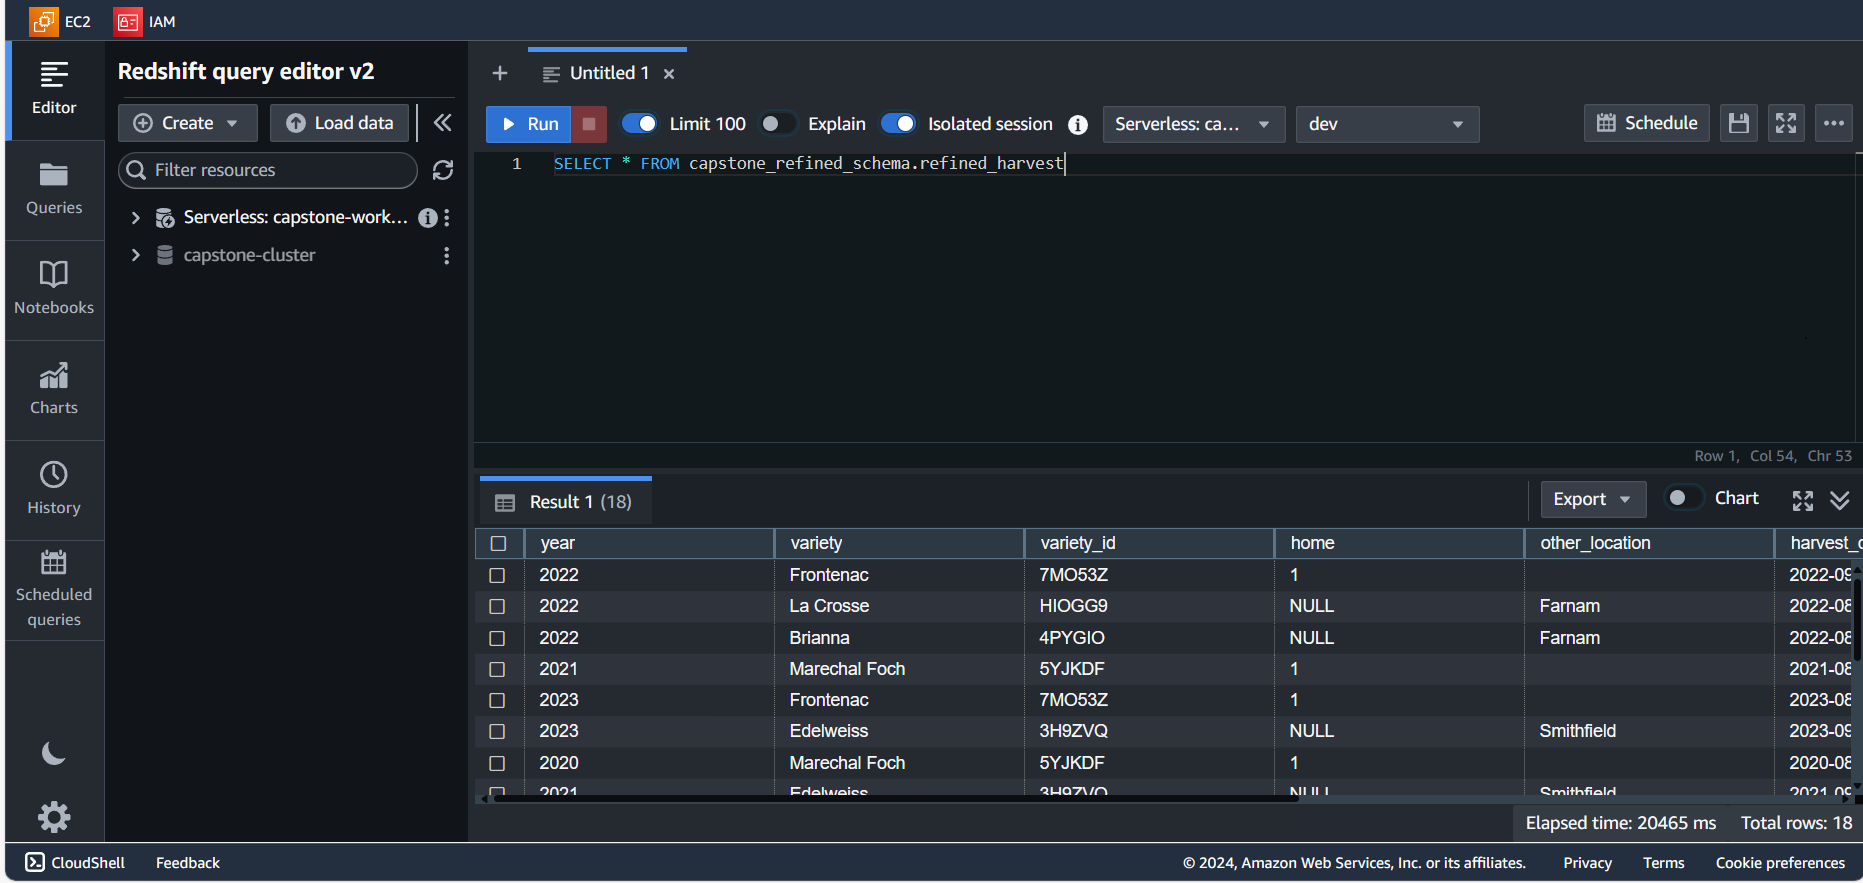

Together with the RDS, s3 bucket, and raw and refined tables from Glue craws, the data lake formation represents gold-tier data warehousing for project.

- bronze layer = raw data
- silver layer = cleansed and conformed data
- gold layer = curated business level-tables ready for consumption

This model is similar to third normal form of data warehousing according to the Kimball model.

## Data visualization as proof of concept

An enhanced map of the vineyard demonstrates proof of concept. The map includes markers for every vine color coordinated by style of wine: 

- dark red = red wine grape
- light gray = white wine grape
- light pink = rose wine grape

A legend for the map permits filtering grapevines by wine color. A popup menu appears when the cursor hovers over each marker indicating plot ID, variety name, wine color, date planted, and estimated yield.

Packages used to create map are folium and pandas. First, a dataframe is created in pandas from a csv file compiled from database tables. Headers include:

> *latitude, longitude, plot ID, date planted, variety name, wine color, and estimated yield.* 

Second, a map is created with folium by establishing the means of latitude and longitude with zoom set at maximum. Third, feature groups are created to sort grapevines by wine color.

A for loop is created with itterrows. Inside of it are two key parts: 

- a popup menu
- an if, elif statement to parse through dataframe

Once iterated, the data are added to the feature groups. Last, the map is saved to local file as html.

In [ ]:
import folium
import pandas as pd

vine_locations = pd.read_csv(r"./enhanced_vineyard_plot.csv")
vine_geolocation = vine_locations[["Latitude", "Longitude", "Plot ID", "Date Planted", "Variety Name", "Wine Color",
                                   "Estimated Yield"]]

m = folium.Map(location=[vine_geolocation.Latitude.mean(), vine_geolocation.Longitude.mean()], zoom_start=20,
    control_scale=True)

feature_red = folium.FeatureGroup(name="Red Wine")
feature_white = folium.FeatureGroup(name="White Wine")
feature_rose = folium.FeatureGroup(name="Rose Wine")

for i, v in vine_geolocation.iterrows():
     popup = """
     Plot ID : <b>%s</b><br>
     Variety Name : <b>%s</b><br>
     Wine Color : <b>%s</b><br>
     Date Planted : <b>%s</b><br>
     Estimated Yield : <b>%s</b><br>
     """ % (v["Plot ID"], v["Variety Name"], v["Wine Color"], v["Date Planted"], v["Estimated Yield"])

     if v["Wine Color"] == "Red":
         folium.CircleMarker(location=[v["Latitude"], v["Longitude"]],
                   radius=1,
                   tooltip=popup,
                   color="darkred",
                   fill_color="darkred",
                   fill=True).add_to(feature_red)
     elif v["Wine Color"] == "White":
         folium.CircleMarker(location=[v["Latitude"], v["Longitude"]],
                   radius=1,
                   tooltip=popup,
                   color="lightgray",
                   fill_color="lightgray",
                   fill=True).add_to(feature_white)
     elif v["Wine Color"] == "Rose":\
         folium.CircleMarker(location=[v["Latitude"], v["Longitude"]],
                   radius=1,
                   tooltip=popup,
                   color="lightpink",
                   fill_color="lighpink",
                   fill=True).add_to(feature_rose)

feature_red.add_to(m)
feature_white.add_to(m)
feature_rose.add_to(m)
folium.LayerControl(collapsed=False).add_to(m)

m.save("enhanced_vineyard_plot.html")

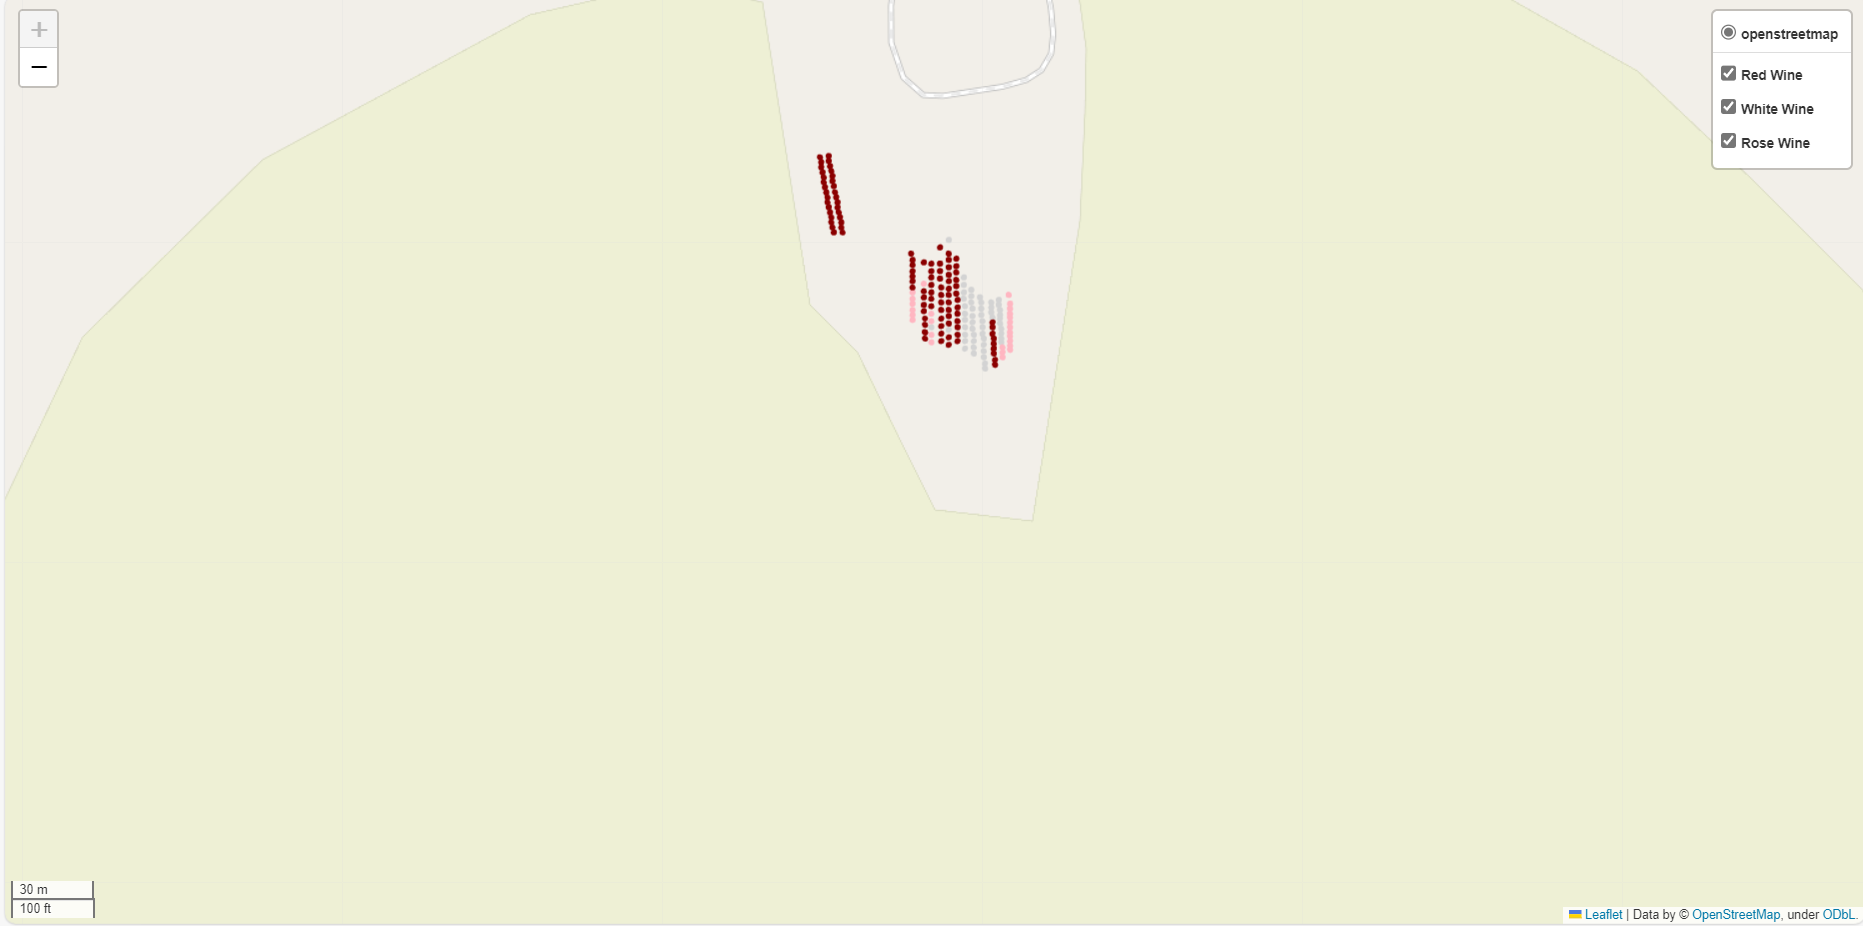

The figure above demonstrates full view of vineyard.

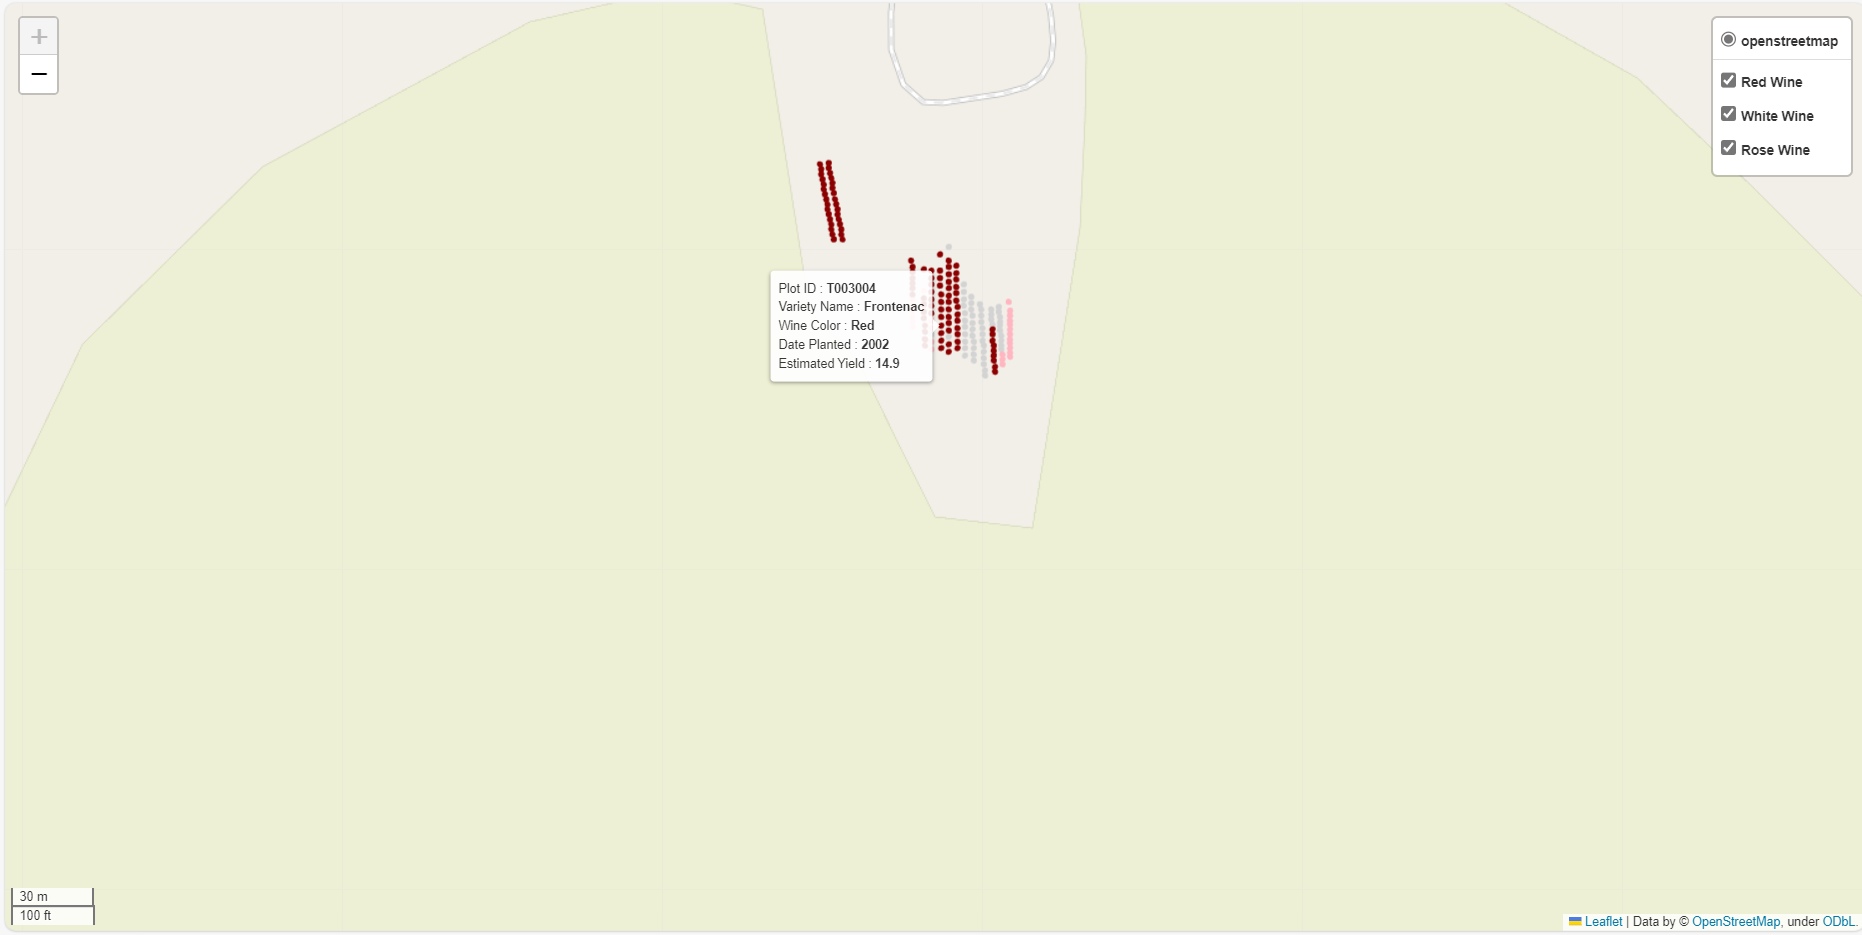

The figure above demonstrates popup menu.

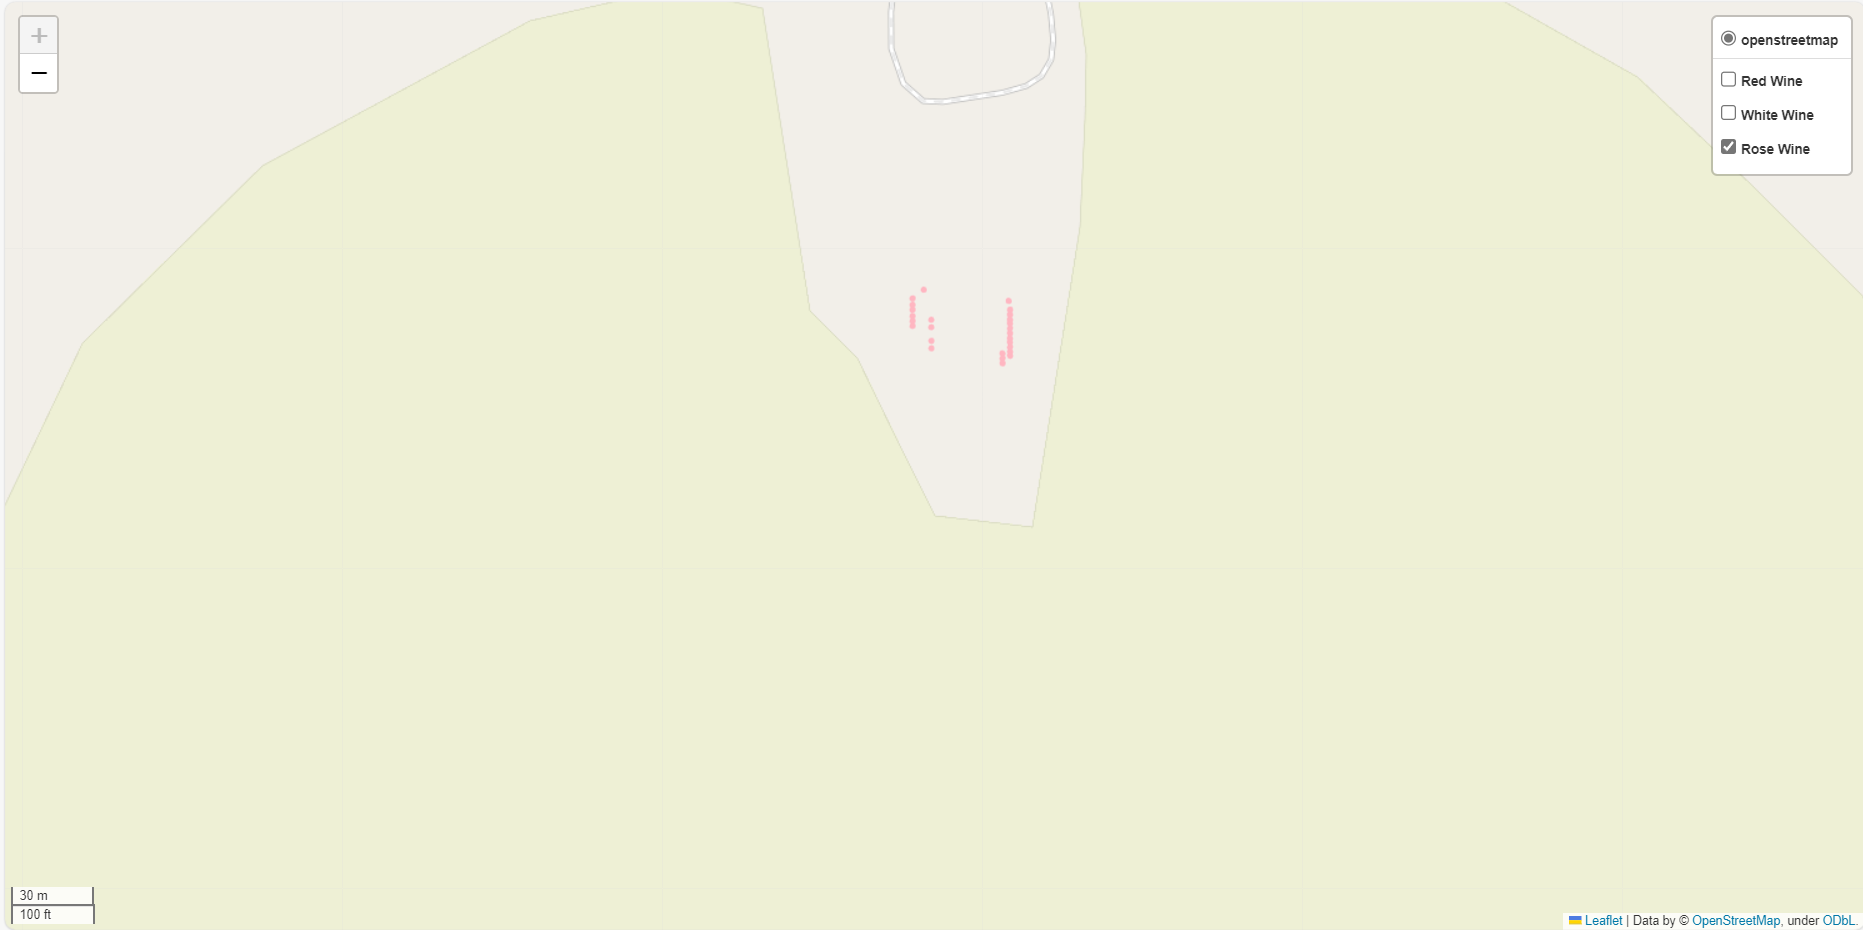

The figure above demonstrates filtering of red and white wine grapes, leaving rose wine grapes in view.

# Conclusion

The use case of data apply to operations of vineyard and winery. Of primary importance are vine management and quality of wine. Data will manage agricultural inputs like fertilizer, sprays, and water. Efficiency in vineyard also includes monitoring of vine health by assessment and yield. The list below enumerates possible use cases in vineyard:  

- Individual vine management 
- Efficient use of inputs 
- Estimate yield with data 

Future uses cases could apply to autonomous machines like drones and harvesters. Drones could pinpoint spray pests during growing season. Cameras and sensors could monitor vines and improve yield. Harvest could be timed to exact moment when grapes are ready to vinify based upon data from winemaking. 